In [12]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [13]:
# Gradient descent optimization
# The learning rate is specified by eta
class GDOptimizer(object):
    def __init__(self, eta):
        self.eta = eta

    def initialize(self, layers):
        pass

    # This function performs one gradient descent step
    # layers is a list of dense layers in the network
    # g is a list of gradients going into each layer before the nonlinear activation
    # a is a list of of the activations of each node in the previous layer going 
    def update(self, layers, g, a):
        m = a[0].shape[1]
        for layer, curGrad, curA in zip(layers, g, a):
            update = np.dot(curGrad,curA.T)
            updateB = np.sum(curGrad,1).reshape(layer.b.shape)
            layer.updateWeights(-self.eta/m * np.dot(curGrad,curA.T))
            layer.updateBias(-self.eta/m * np.sum(curGrad,1).reshape(layer.b.shape))

# Cost function used to compute prediction errors
class QuadraticCost(object):

    # Compute the squared error between the prediction yp and the observation y
    # This method should compute the cost per element such that the output is the
    # same shape as y and yp
    @staticmethod
    def fx(y,yp):
        return 0.5 * np.square(yp-y)

    # Derivative of the cost function with respect to yp
    @staticmethod
    def dx(y,yp):
        return y - yp

# Sigmoid function fully implemented as an example
class SigmoidActivation(object):
    @staticmethod
    def fx(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dx(z):
        return SigmoidActivation.fx(z) * (1 - SigmoidActivation.fx(z))
        
# Hyperbolic tangent function
class TanhActivation(object):

    # Compute tanh for each element in the input z
    @staticmethod
    def fx(z):
        return np.tanh(z)

    # Compute the derivative of the tanh function with respect to z
    @staticmethod
    def dx(z):
        return 1 - np.square(np.tanh(z))

# Rectified linear unit
class ReLUActivation(object):
    @staticmethod
    def fx(z):
        return np.maximum(0,z)

    @staticmethod
    def dx(z):
        return (z>0).astype('float')

# Linear activation
class LinearActivation(object):
    @staticmethod
    def fx(z):
        return z

    @staticmethod
    def dx(z):
        return np.ones(z.shape)

# This class represents a single hidden or output layer in the neural network
class DenseLayer(object):

    # numNodes: number of hidden units in the layer
    # activation: the activation function to use in this layer
    def __init__(self, numNodes, activation):
        self.numNodes = numNodes
        self.activation = activation

    def getNumNodes(self):
        return self.numNodes

    # Initialize the weight matrix of this layer based on the size of the matrix W
    def initialize(self, fanIn, scale=1.0):
        s = scale * np.sqrt(6.0 / (self.numNodes + fanIn))
        self.W = np.random.normal(0, s,
                                   (self.numNodes,fanIn))
        #self.b = np.zeros((self.numNodes,1))
        self.b = np.random.uniform(-1,1,(self.numNodes,1))

    # Apply the activation function of the layer on the input z
    def a(self, z):
        return self.activation.fx(z)

    # Compute the linear part of the layer
    # The input a is an n x k matrix where n is the number of samples
    # and k is the dimension of the previous layer (or the input to the network)
    def z(self, a): 
        #print('a:\n'+str(a))
        #print('Wa:\n'+str(self.W.dot(a)))
        return self.W.dot(a) + self.b # Note, this is implemented where we assume a is k x n

    # Compute the derivative of the layer's activation function with respect to z
    # where z is the output of the above function.
    # This derivative does not contain the derivative of the matrix multiplication
    # in the layer.  That part is computed below in the model class.
    def dx(self, z):
        return self.activation.dx(z)

    # Update the weights of the layer by adding dW to the weights
    def updateWeights(self, dW):
        self.W = self.W + dW

    # Update the bias of the layer by adding db to the bias
    def updateBias(self, db):
        self.b = self.b + db

# This class handles stacking layers together to form the completed neural network
class Model(object):

    # inputSize: the dimension of the inputs that go into the network
    def __init__(self, inputSize):
        self.layers = []
        self.inputSize = inputSize

    # Add a layer to the end of the network
    def addLayer(self, layer):
        self.layers.append(layer)

    # Get the output size of the layer at the given index
    def getLayerSize(self, index):
        if index >= len(self.layers):
            return self.layers[-1].getNumNodes()
        elif index < 0:
            return self.inputSize
        else:
            return self.layers[index].getNumNodes()

    # Initialize the weights of all of the layers in the network and set the cost
    # function to use for optimization
    def initialize(self, cost, initializeLayers=True):
        self.cost = cost
        if initializeLayers:
            for i in range(0,len(self.layers)):
                if i == len(self.layers) - 1:
                    self.layers[i].initialize(self.getLayerSize(i-1))
                else:
                    self.layers[i].initialize(self.getLayerSize(i-1))

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    # This function returns
    # yp - the output of the network
    # a - a list of inputs for each layer of the newtork where
    #     a[i] is the input to layer i
    # z - a list of values for each layer after evaluating layer.z(a) but
    #     before evaluating the nonlinear function for the layer
    def evaluate(self, x):
        curA = x.T
        a = [curA]
        z = []
        for layer in self.layers:
            z.append(layer.z(curA))
            curA = layer.a(z[-1])
            a.append(curA)
        yp = a.pop()
        return yp, a, z

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    def predict(self, a):
        a,_,_ = self.evaluate(a)
        return a.T

    # Train the network given the inputs x and the corresponding observations y
    # The network should be trained for numEpochs iterations using the supplied
    # optimizer
    def train(self, x, y, numEpochs, optimizer):

        # Initialize some stuff
        n = x.shape[0]
        hist = []
        optimizer.initialize(self.layers)
        
        # Run for the specified number of epochs
        for epoch in range(0,numEpochs):

            # Feed forward
            # Save the output of each layer in the list a
            # After the network has been evaluated, a should contain the
            # input x and the output of each layer except for the last layer
            yp, a, z = self.evaluate(x)

            # Compute the error
            C = self.cost.fx(yp,y.T)
            d = self.cost.dx(yp,y.T)
            grad = []

            # Backpropogate the error
            idx = len(self.layers)
            for layer, curZ in zip(reversed(self.layers),reversed(z)):
                idx = idx - 1
                # Here, we compute dMSE/dz_i because in the update
                # function for the optimizer, we do not give it
                # the z values we compute from evaluating the network
                grad.insert(0,np.multiply(d,layer.dx(curZ)))
                d = np.dot(layer.W.T,grad[0])

            # Update the errors
            optimizer.update(self.layers, grad, a)

            # Compute the error at the end of the epoch
            yh = self.predict(x)
            C = self.cost.fx(yh,y)
            C = np.mean(C)
            hist.append(C)
        return hist

    def trainBatch(self, x, y, batchSize, numEpochs, optimizer):

        # Copy the data so that we don't affect the original one when shuffling
        x = x.copy()
        y = y.copy()
        hist = []
        n = x.shape[0]
        
        for epoch in np.arange(0,numEpochs):
            
            # Shuffle the data
            r = np.arange(0,x.shape[0])
            x = x[r,:]
            y = y[r,:]
            e = []

            # Split the data in chunks and run SGD
            for i in range(0,n,batchSize):
                end = min(i+batchSize,n)
                batchX = x[i:end,:]
                batchY = y[i:end,:]
                e += self.train(batchX, batchY, 1, optimizer)
            hist.append(np.mean(e))

        return hist


########################################################################
######### Part b #######################################################
########################################################################

########################################################################
#########  Gradient Computing and MLE ##################################
########################################################################
def compute_gradient_of_likelihood(single_obj_loc, sensor_loc, 
                                single_distance, noise = 1):
    """
    Compute the gradient of the loglikelihood function for part a.   
    
    Input:
    single_obj_loc: 1 * d numpy array. 
    Location of the single object.
    
    sensor_loc: k * d numpy array. 
    Location of sensor.
    
    single_distance: k dimensional numpy array. 
    Observed distance of the object.
    
    Output:
    grad: d-dimensional numpy array.
    
    """
    loc_difference = single_obj_loc - sensor_loc # k * d.
    phi = np.linalg.norm(loc_difference, axis = 1) # k. 
    weight = (phi - single_distance) / phi # k.
    
    grad = -np.sum(np.expand_dims(weight,1)*loc_difference, 
                   axis = 0)/noise ** 2 # d
    return grad 

########################################################################
######### Part c #################################################
########################################################################
def log_likelihood(obj_loc, sensor_loc, distance, noise = 1): 
    """
    This function computes the log likelihood (as expressed in Part a).
    Input: 
    obj_loc: shape [1,2]
    sensor_loc: shape [7,2]
    distance: shape [7]
    Output: 
    The log likelihood function value. 
    """  
    diff_distance = np.sqrt(np.sum((sensor_loc - obj_loc)**2, axis = 1))- distance
    func_value = -sum((diff_distance)**2)/(2 * noise ** 2)
    return func_value
 


########################################################################
######### Part e, f, g #################################################
########################################################################

########################################################################
#########  Gradient Computing and MLE ##################################
########################################################################
def compute_grad_likelihood_part_e(sensor_loc, obj_loc, distance, noise = 1):
    """
    Compute the gradient of the loglikelihood function for part d.   
    
    Input:
    sensor_loc: k * d numpy array. 
    Location of sensors.
    
    obj_loc: n * d numpy array. 
    Location of the objects.
    
    distance: n * k dimensional numpy array. 
    Observed distance of the object.
    
    Output:
    grad: k * d numpy array.
    """
    grad = np.zeros(sensor_loc.shape)
    for i, single_sensor_loc in enumerate(sensor_loc):
        single_distance = distance[:,i] 
        grad[i] = compute_gradient_of_likelihood(single_sensor_loc, 
                     obj_loc, single_distance, noise)
        
    return grad

def find_mle_by_grad_descent_part_e(initial_sensor_loc, 
           obj_loc, distance, noise = 1, lr=0.001, num_iters = 1000):
    """
    Compute the gradient of the loglikelihood function for part a.   
    
    Input:
    initial_sensor_loc: k * d numpy array. 
    Initialized Location of the sensors.
    
    obj_loc: n * d numpy array. Location of the n objects.
    
    distance: n * k dimensional numpy array. 
    Observed distance of the n object.
    
    Output:
    sensor_loc: k * d numpy array. The mle for the location of the object.
    
    """    
    sensor_loc = initial_sensor_loc
    for t in range(num_iters):
        sensor_loc += lr * compute_grad_likelihood_part_e(
            sensor_loc, obj_loc, distance, noise) 
        
    return sensor_loc 
 
 ########################################################################
#########  Estimate distance given estimated sensor locations. ######### 
########################################################################

def compute_distance_with_sensor_and_obj_loc(sensor_loc, obj_loc):
    """
    stimate distance given estimated sensor locations.  
    
    Input:
    sensor_loc: k * d numpy array. 
    Location of the sensors.
    
    obj_loc: n * d numpy array. Location of the n objects.
    
    Output:
    distance: n * k dimensional numpy array. 
    """ 
    estimated_distance = scipy.spatial.distance.cdist(obj_loc, 
                                            sensor_loc, 
                                            metric='euclidean')
    return estimated_distance 
 
########################################################################
#########  Data Generating Functions ###################################
########################################################################

def generate_sensors(num_sensors = 7, spatial_dim = 2):
    """
    Generate sensor locations. 
    Input:
    num_sensors: The number of sensors.
    spatial_dim: The spatial dimension.
    Output:
    sensor_loc: num_sensors * spatial_dim numpy array.
    """
    sensor_loc = 100*np.random.randn(num_sensors,spatial_dim)
    return sensor_loc

def generate_dataset(sensor_loc, num_sensors = 7, spatial_dim = 2, 
                 num_data = 1, original_dist = True, noise = 1):
    """
    Generate the locations of n points.  

    Input:
    sensor_loc: num_sensors * spatial_dim numpy array. Location of sensor. 
    num_sensors: The number of sensors.
    spatial_dim: The spatial dimension.
    num_data: The number of points.
    original_dist: Whether the data are generated from the original 
    distribution. 

    Output:
    obj_loc: num_data * spatial_dim numpy array. The location of the num_data objects. 
    distance: num_data * num_sensors numpy array. The distance between object and 
    the num_sensors sensors. 
    """
    assert num_sensors, spatial_dim == sensor_loc.shape

    obj_loc = 100*np.random.randn(num_data, spatial_dim)
    if not original_dist:
       obj_loc += 1000

    distance = scipy.spatial.distance.cdist(obj_loc, 
                                           sensor_loc, 
                                           metric='euclidean')
    distance += np.random.randn(num_data, num_sensors) * noise
    return distance, obj_loc




## a) five models

In [14]:
# Generative Model
def obj_loc_predict_gd(distance, sensor_loc, lr = 0.01):
    obj_loc = np.zeros((np.size(distance,axis = 0),2), dtype = np.float)
    for i in range( np.size(obj_loc,axis = 0)):
        for k in range(100):
            grad = compute_gradient_of_likelihood(obj_loc[i,:], sensor_loc, distance[i])
            obj_loc[i,:] = obj_loc[i,:] + grad * lr
    return obj_loc

def generative_model(distance_train, obj_loc_train, distance_test, obj_loc_test):
    initial_sensor_loc = np.zeros((np.size(distance_train,axis = 1),2), dtype = np.float)
    sensor_loc = find_mle_by_grad_descent_part_e(initial_sensor_loc, obj_loc_train, 
                                                 distance_train, lr=0.0001, num_iters = 1000)
    obj_loc_predict = obj_loc_predict_gd(distance_test, sensor_loc, 0.0001)
    obj_loc_predict_train = obj_loc_predict_gd(distance_train, sensor_loc)
    test_error = mean_square_root_error(obj_loc_test, obj_loc_predict)
    training_error = mean_square_root_error(obj_loc_train, obj_loc_predict_train)
    return test_error, training_error

# Linear Model
def linear_reg_model(distance_train, obj_loc_train):
    '''
    Input: distance_train, obj_loc_train
    output: linear model
    '''
    reg = LinearRegression()
    reg.fit(distance_train, obj_loc_train)
    return reg

def linear_error(distance_train, obj_loc_train, distance_test, obj_loc_test):
    linear_reg = linear_reg_model(distance_train, obj_loc_train)
    linear_reg
    obj_loc_predict = linear_reg.predict(distance_test)
    obj_loc_predict_train = linear_reg.predict(distance_train)
    test_error = mean_square_root_error(obj_loc_test, obj_loc_predict)
    training_error = mean_square_root_error(obj_loc_train, obj_loc_predict_train)
    return test_error, training_error

# Second/Third Order Polynomial Feature
def poly_reg_model(distance_train, obj_loc_train, distance_test, degree = 2):
    '''
    input: distance_train, obj_loc_train
    '''
    poly = PolynomialFeatures(degree)
    distance_train_poly = poly.fit_transform(distance_train)
    distance_test_poly = poly.fit_transform(distance_test)
    reg = LinearRegression()
    reg.fit(distance_train_poly, obj_loc_train)
    train_predict = reg.predict(distance_train_poly)
    error = mean_square_root_error(obj_loc_train, train_predict)
    return reg, distance_test_poly, error

def poly_error(distance_train, obj_loc_train, distance_test, obj_loc_test, degree = 2):
    poly_reg, distance_test_poly, training_error = poly_reg_model(distance_train, 
                                                                  obj_loc_train,
                                                                  distance_test, degree)
    obj_loc_predict = poly_reg.predict(distance_test_poly)
    test_error = mean_square_root_error(obj_loc_test, obj_loc_predict)
    return test_error, training_error 
 
# Neural Network
def NN_error(distance_train, obj_loc_train, distance_test, obj_loc_test, 
             layer = 2, node_num = 100, eta = 1):
    model = Model(distance_train.shape[1])
    for i in range(layer):
        model.addLayer(DenseLayer(node_num,ReLUActivation()))
    model.addLayer(DenseLayer(2,LinearActivation()))
    model.initialize(QuadraticCost())
    model.train(distance_train, obj_loc_train, 500, GDOptimizer(eta))
    obj_loc_predict =  model.predict(distance_test)
    obj_loc_predict_train = model.predict(distance_train)
    test_error = mean_square_root_error(obj_loc_test, obj_loc_predict)
    training_error = mean_square_root_error(obj_loc_train, obj_loc_predict_train)
    return test_error, training_error

# Error for evaluation 
def mean_square_root_error(test, predict):
    return np.sum(np.power(np.sum(np.power(test - predict,2),
                                  axis = 1),1/2))/np.size(test,axis = 0)
    

## b) plot test / shift test and training errors

In [16]:
np.random.seed(100)
sensor_loc = generate_sensors()

num_data_list = range(10,310,20)
num_data_test = 1000
# generate test data num_data_test = 1000
distance_test, obj_loc_test = generate_dataset(sensor_loc, 7, 2, 
                                               num_data = num_data_test)
error_test = []
for i in range(5):
    error_test.append([])

error_training = []
for i in range(5):
    error_training.append([])
    
error_test_shift = []
for i in range(5):
    error_test_shift.append([])

    
for num_data in num_data_list:
    # generate training data
    distance_train, obj_loc_train = generate_dataset(sensor_loc, 7, 2, num_data)
    # linear model
    test_error, training_error = linear_error(distance_train, obj_loc_train,
                                              distance_test, obj_loc_test)
    error_test[0].append(test_error)
    error_training[0].append(training_error)
    # polynomial featurepoly_reg 2
    test_error, training_error = poly_error(distance_train, obj_loc_train, 
                                            distance_test, obj_loc_test, degree = 2)
    error_test[1].append(test_error)
    error_training[1].append(training_error)
    # polynomial featurepoly_reg 3
    test_error, training_error = poly_error(distance_train, obj_loc_train,
                                            distance_test, obj_loc_test, degree = 3)
    error_test[2].append(test_error)
    error_training[2].append(training_error)
    # Neural Network
    test_error, training_error = NN_error(distance_train, obj_loc_train,
                                          distance_test, obj_loc_test, eta = 0.000001)
    error_test[3].append(test_error)
    error_training[3].append(training_error)
    # generative model
    test_error, training_error = generative_model(distance_train, obj_loc_train,
                                                  distance_test, obj_loc_test)
    error_test[4].append(test_error)
    error_training[4].append(training_error)
    
    distance_train, obj_loc_train = generate_dataset(sensor_loc, 7, 2,
                                                     num_data, original_dist= False)
    test_error,_ = linear_error(distance_train, obj_loc_train,
                                distance_test, obj_loc_test)
    error_test_shift[0].append(test_error)
    # polynomial featurepoly_reg 2
    test_error,_ = poly_error(distance_train, obj_loc_train,
                              distance_test, obj_loc_test, degree = 2)
    error_test_shift[1].append(test_error)
    # polynomial featurepoly_reg 3
    test_error,_ = poly_error(distance_train, obj_loc_train,
                              distance_test, obj_loc_test, degree = 3)
    error_test_shift[2].append(test_error)
    # Neural Network
    test_error,_ = NN_error(distance_train, obj_loc_train,
                            distance_test, obj_loc_test, eta = 0.00000000005)
    error_test_shift[3].append(test_error)
    # generative model
    test_error, _ = generative_model(distance_train,
                                     obj_loc_train, distance_test, obj_loc_test)
    error_test_shift[4].append(test_error)

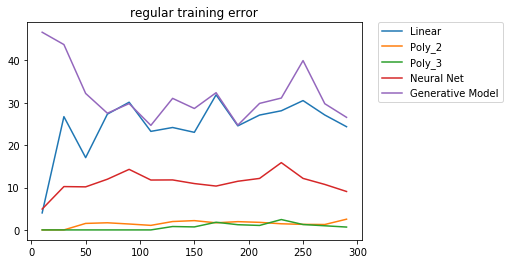

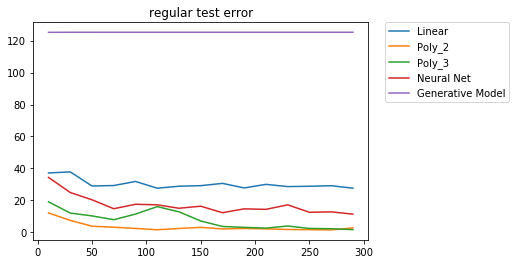

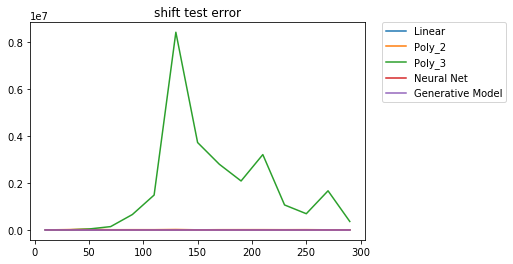

In [17]:
line_name = ['Linear', 'Poly_2', 'Poly_3', 'Neural Net', 'Generative Model']
for i in range(5):
    plt.plot(num_data_list,error_training[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('regular training error')
plt.show()

for i in range(5):
    plt.plot(num_data_list,error_test[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('regular test error')
plt.show()

for i in range(5):
    plt.plot(num_data_list,error_test_shift[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('shift test error')
plt.show()


## c)

In [18]:
node_num_list = range(100,550,50)
distance_train, obj_loc_train = generate_dataset(sensor_loc, 7, 2, 200)
error_test = []
for i in range(5):
    error_test.append([])

error_training = []
for i in range(5):
    error_training.append([])
    
for node_num in node_num_list:
    test_error, training_error = NN_error(distance_train, obj_loc_train,
                                          distance_test, obj_loc_test, layer = 2,
                                          node_num = node_num, eta = 0.000001)
    error_test[3].append(test_error)
    error_training[3].append(training_error)

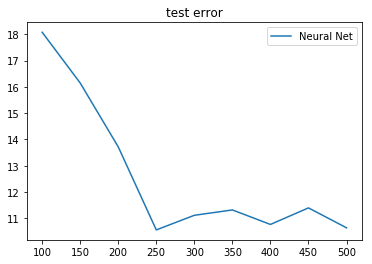

In [19]:
plt.plot(node_num_list,error_test[3], label = line_name[3])
plt.legend()
plt.title('test error')
plt.show()

## d)

In [153]:
def solve_node_num(num_para, layer_num, input_num = 7, output_num = 2):
    b = input_num + output_num
    a = layer_num - 1
    c = - num_para
    if a > 0:
        node_num = (int)((-b + np.sqrt(b**2 - 4*a*c))/(2*a))
    else:
        node_num = (int)(-c/b)
    return node_num

layer_list = range(1,5,1)
distance_train, obj_loc_train = generate_dataset(sensor_loc, 7, 2, 200)
error_test = []
for i in range(5):
    error_test.append([])

error_training = []
for i in range(5):
    error_training.append([])
    
for layer in layer_list:
    node_num = solve_node_num(10000, layer)
    test_error, training_error = NN_error(distance_train, obj_loc_train, distance_test, obj_loc_test, layer, node_num = node_num, eta = 0.0000001)
    error_test[3].append(test_error)
    error_training[3].append(training_error)

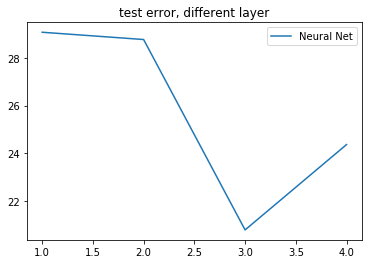

In [154]:
plt.plot(layer_list,error_test[3], label = line_name[3])
plt.legend()
plt.title('test error, different layer')
plt.show()

## k = 3 is better since it gives me a smaller test error

## e)

In [204]:
np.random.seed(100)
sensor_loc = generate_sensors()

num_data_list = range(10,310,20)

# generate test data num_data_test = 1000
distance_test, obj_loc_test = generate_dataset(sensor_loc, 7, 2,
                                               num_data = num_data_test)
error_test = []
for i in range(5):
    error_test.append([])

error_training = []
for i in range(5):
    error_training.append([])
    
error_test_shift = []
for i in range(5):
    error_test_shift.append([])

    
for num_data in num_data_list:
    # generate training data
    distance_train, obj_loc_train = generate_dataset(sensor_loc, 7, 2, num_data)
    # linear model
    test_error, training_error = linear_error(distance_train, obj_loc_train,
                                              distance_test, obj_loc_test)
    error_test[0].append(test_error)
    error_training[0].append(training_error)
    # polynomial featurepoly_reg 2
    test_error, training_error = poly_error(distance_train, obj_loc_train,
                                            distance_test, obj_loc_test, degree = 2)
    error_test[1].append(test_error)
    error_training[1].append(training_error)
    # polynomial featurepoly_reg 3
    test_error, training_error = poly_error(distance_train, obj_loc_train,
                                            distance_test, obj_loc_test, degree = 3)
    error_test[2].append(test_error)
    error_training[2].append(training_error)
    # Neural Network
    test_error, training_error = NN_error(distance_train, obj_loc_train,
                                          distance_test, obj_loc_test, layer = 3,
                                          node_num = 250, eta = 0.000001)
    error_test[3].append(test_error)
    error_training[3].append(training_error)
     # generative model
    test_error, training_error = generative_model(distance_train, obj_loc_train,
                                                  distance_test, obj_loc_test)
    error_test[4].append(test_error)
    error_training[4].append(training_error)
    
    distance_train, obj_loc_train = generate_dataset(sensor_loc, 7, 2, num_data,
                                                     original_dist= False)
    test_error,_ = linear_error(distance_train, obj_loc_train,
                                distance_test, obj_loc_test)
    error_test_shift[0].append(test_error)
    # polynomial featurepoly_reg 2
    test_error,_ = poly_error(distance_train, obj_loc_train, distance_test,
                              obj_loc_test, degree = 2)
    error_test_shift[1].append(test_error)
    # polynomial featurepoly_reg 3
    test_error,_ = poly_error(distance_train, obj_loc_train, distance_test,
                              obj_loc_test, degree = 3)
    error_test_shift[2].append(test_error)
    # Neural Network
    test_error,_ = NN_error(distance_train, obj_loc_train, distance_test,
                            obj_loc_test, layer = 3, node_num = 250, eta = 0.00000000005)
    error_test_shift[3].append(test_error)
    # generative model
    test_error, _ = generative_model(distance_train, obj_loc_train,
                                     distance_test, obj_loc_test)
    error_test_shift[4].append(test_error)

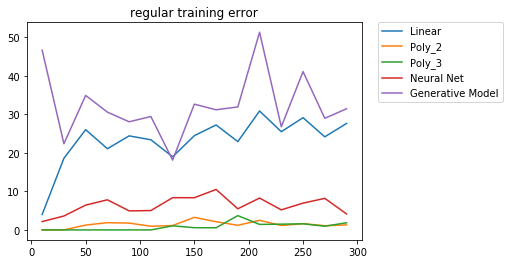

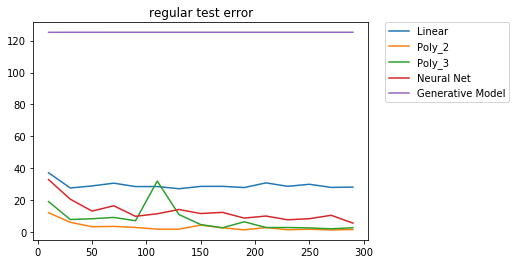

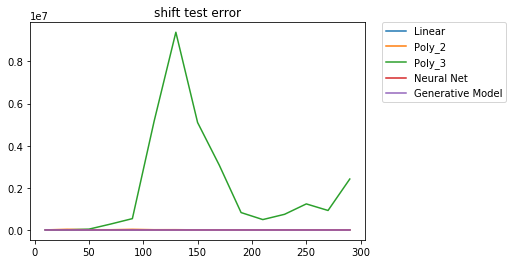

In [205]:
line_name = ['Linear', 'Poly_2', 'Poly_3', 'Neural Net', 'Generative Model']
for i in range(5):
    plt.plot(num_data_list,error_training[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('regular training error')
plt.show()

for i in range(5):
    plt.plot(num_data_list,error_test[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('regular test error')
plt.show()

for i in range(5):
    plt.plot(num_data_list,error_test_shift[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('shift test error')
plt.show()

## f)

In [159]:
def NN_SGD_error(distance_train, obj_loc_train, distance_test,
                 obj_loc_test, batch_size = 5, layer = 2, node_num = 100, eta = 1):
    model = Model(distance_train.shape[1])
    for i in range(layer):
        model.addLayer(DenseLayer(node_num,ReLUActivation()))
    model.addLayer(DenseLayer(2,LinearActivation()))
    model.initialize(QuadraticCost())
    model.trainBatch(distance_train, obj_loc_train, batch_size, 500, GDOptimizer(eta))
    obj_loc_predict =  model.predict(distance_test)
    obj_loc_predict_train = model.predict(distance_train)
    test_error = mean_square_root_error(obj_loc_test, obj_loc_predict)
    training_error = mean_square_root_error(obj_loc_train, obj_loc_predict_train)
    return test_error, training_error

In [160]:
np.random.seed(100)
sensor_loc = generate_sensors()

num_data_list = range(10,310,20)

# generate test data num_data_test = 1000
distance_test, obj_loc_test = generate_dataset(sensor_loc, 7, 2, num_data = num_data_test)
error_test = []
for i in range(5):
    error_test.append([])

error_training = []
for i in range(5):
    error_training.append([])
    
error_test_shift = []
for i in range(5):
    error_test_shift.append([])

batch_size = 5
for num_data in num_data_list:
    # generate training data
    distance_train, obj_loc_train = generate_dataset(sensor_loc, 7, 2, num_data)
    # Neural Network
    test_error, training_error = NN_error(distance_train, obj_loc_train,
                                          distance_test, obj_loc_test, 
                                          layer = 3, node_num = 250, eta = 0.000001)
    error_test[3].append(test_error)
    error_training[3].append(training_error)
    test_error, training_error = NN_SGD_error(distance_train, obj_loc_train,
                                              distance_test, obj_loc_test, 
                                              batch_size, layer = 3,
                                              node_num = 250, eta = 0.000001)
    error_test[2].append(test_error)
    error_training[2].append(training_error)

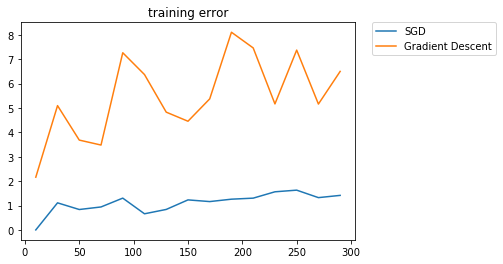

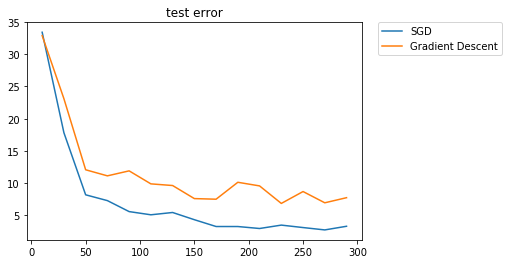

In [162]:
line_name = ['', '', 'SGD', 'Gradient Descent']
for i in range(2,4,1):
    plt.plot(num_data_list,error_training[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('training error')
plt.show()

for i in range(2,4,1):
    plt.plot(num_data_list,error_test[i], label = line_name[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('test error')
plt.show()